In [ ]:
#!source activate jgrace1

In [1]:
cd /disk/ocean/jgrace

/disk/ocean/jgrace


In [2]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from torch.utils.data import Dataset, DataLoader

from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

import pickle
import subprocess
import os

In [3]:
import spacy
nlp = spacy.load('en_vectors_web_lg') # For the glove embeddings

In [4]:
import umap

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
# set which GPU to use
GPU_ID = 1
torch.cuda.set_device(GPU_ID)
print(torch.cuda.current_device())

1


In [6]:
USE_CUDA = torch.cuda.is_available()
print('Use_CUDA={}'.format(USE_CUDA))

if USE_CUDA:
    device = torch.device("cuda")
    print('current_device={}'.format(torch.cuda.current_device()))
else:
    device = torch.device("cpu")

Use_CUDA=True
current_device=1


In [7]:
!nvidia-smi

Tue Jul 31 19:04:35 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   29C    P8    17W / 250W |     11MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:83:00.0 Off |                  N/A |
| 22%   56C    P2    71W / 250W |    447MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [8]:
from seq2seq_utils import *

In [9]:
# global setting for seq2seq_utils

PAD = 0
BOS = 1
EOS = 2
UNK = 3

MAX_SRC_DOC_LENGTH = 1000
MAX_TGT_DOC_LENGTH = 100
MAX_DOC_LENGTH = 200

## Build models

### Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding=None, rnn_type='LSTM', hidden_size=128, num_layers=1, dropout=0.3, bidirectional=True):
        super(EncoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size // self.num_directions
        
        self.embedding = embedding
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                           input_size=self.word_vec_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.dropout, 
                           bidirectional=self.bidirectional)
        
    def forward(self, src_seqs, src_lens, hidden=None):
        """
        Args:
            - src_seqs: (max_src_len, batch_size)
            - src_lens: (batch_size)
        Returns:
            - outputs: (max_src_len, batch_size, hidden_size * num_directions)
            - hidden : (num_layers, batch_size, hidden_size * num_directions)
        """
        
        # (max_src_len, batch_size) => (max_src_len, batch_size, word_vec_size)
        emb = self.embedding(src_seqs)

        # packed_emb:
        # - data: (sum(batch_sizes), word_vec_size)
        # - batch_sizes: list of batch sizes
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb, src_lens)

        # rnn(gru) returns:
        # - packed_outputs: shape same as packed_emb
        # - hidden: (num_layers * num_directions, batch_size, hidden_size) 
        packed_outputs, hidden = self.rnn(packed_emb, hidden)

        # outputs: (max_src_len, batch_size, hidden_size * num_directions)
        # output_lens == src_lensˇ
        outputs, output_lens =  nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        if self.bidirectional:
            # (num_layers * num_directions, batch_size, hidden_size) 
            # => (num_layers, batch_size, hidden_size * num_directions)
            hidden = self._cat_directions(hidden)
        
        return outputs, hidden
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden

### Decoder with "general attention" mechanism

In [11]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, encoder, embedding=None, attention=True, bias=True, tie_embeddings=False, dropout=0.3):
        """ General attention in `Effective Approaches to Attention-based Neural Machine Translation`
            Ref: https://arxiv.org/abs/1508.04025
            
            Share input and output embeddings:
            Ref:
                - "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
                   https://arxiv.org/abs/1608.05859
                - "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
                   https://arxiv.org/abs/1611.01462
        """
        super(LuongAttnDecoderRNN, self).__init__()
        
        self.hidden_size = encoder.hidden_size * encoder.num_directions
        self.num_layers = encoder.num_layers
        self.dropout = dropout
        self.embedding = embedding
        self.attention = attention
        self.tie_embeddings = tie_embeddings
        
        self.vocab_size = self.embedding.num_embeddings
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = encoder.rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                            input_size=self.word_vec_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout)
        
        if self.attention:
            self.W_a = nn.Linear(encoder.hidden_size * encoder.num_directions,
                                 self.hidden_size, bias=bias)
            self.W_c = nn.Linear(encoder.hidden_size * encoder.num_directions + self.hidden_size, 
                                 self.hidden_size, bias=bias)
        
        if self.tie_embeddings:
            self.W_proj = nn.Linear(self.hidden_size, self.word_vec_size, bias=bias)
            self.W_s = nn.Linear(self.word_vec_size, self.vocab_size, bias=bias)
            self.W_s.weight = self.embedding.weight
        else:
            self.W_s = nn.Linear(self.hidden_size, self.vocab_size, bias=bias)
        
    def forward(self, input_seq, decoder_hidden, encoder_outputs, src_lens):
        """ Args:
            - input_seq      : (batch_size)
            - decoder_hidden : (t=0) last encoder hidden state (num_layers * num_directions, batch_size, hidden_size) 
                               (t>0) previous decoder hidden state (num_layers, batch_size, hidden_size)
            - encoder_outputs: (max_src_len, batch_size, hidden_size * num_directions)
        
            Returns:
            - output           : (batch_size, vocab_size)
            - decoder_hidden   : (num_layers, batch_size, hidden_size)
            - attention_weights: (batch_size, max_src_len)
        """        
        # (batch_size) => (seq_len=1, batch_size)
        input_seq = input_seq.unsqueeze(0)
        
        # (seq_len=1, batch_size) => (seq_len=1, batch_size, word_vec_size) 
        emb = self.embedding(input_seq)
        
        # rnn returns:
        # - decoder_output: (seq_len=1, batch_size, hidden_size)
        # - decoder_hidden: (num_layers, batch_size, hidden_size)
        decoder_output, decoder_hidden = self.rnn(emb, decoder_hidden)

        # (seq_len=1, batch_size, hidden_size) => (batch_size, seq_len=1, hidden_size)
        decoder_output = decoder_output.transpose(0,1)
        
        """ 
        ------------------------------------------------------------------------------------------
        Notes of computing attention scores
        ------------------------------------------------------------------------------------------
        # For-loop version:

        max_src_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        attention_scores = Variable(torch.zeros(batch_size, max_src_len))

        # For every batch, every time step of encoder's hidden state, calculate attention score.
        for b in range(batch_size):
            for t in range(max_src_len):
                # Loung. eq(8) -- general form content-based attention:
                attention_scores[b,t] = decoder_output[b].dot(attention.W_a(encoder_outputs[t,b]))

        ------------------------------------------------------------------------------------------
        # Vectorized version:

        1. decoder_output: (batch_size, seq_len=1, hidden_size)
        2. encoder_outputs: (max_src_len, batch_size, hidden_size * num_directions)
        3. W_a(encoder_outputs): (max_src_len, batch_size, hidden_size)
                        .transpose(0,1)  : (batch_size, max_src_len, hidden_size) 
                        .transpose(1,2)  : (batch_size, hidden_size, max_src_len)
        4. attention_scores: 
                        (batch_size, seq_len=1, hidden_size) * (batch_size, hidden_size, max_src_len) 
                        => (batch_size, seq_len=1, max_src_len)
        """
        
        if self.attention:
            # attention_scores: (batch_size, seq_len=1, max_src_len)
            attention_scores = torch.bmm(decoder_output, self.W_a(encoder_outputs).transpose(0,1).transpose(1,2))

            # attention_mask: (batch_size, seq_len=1, max_src_len)
            attention_mask = sequence_mask(src_lens).unsqueeze(1)

            # Fills elements of tensor with `-float('inf')` where `mask` is 1.
            attention_scores.data.masked_fill_(1 - attention_mask.data, -float('inf'))

            # attention_weights: (batch_size, seq_len=1, max_src_len) => (batch_size, max_src_len) for `F.softmax` 
            # => (batch_size, seq_len=1, max_src_len)
            try: # torch 0.3.x
                attention_weights = F.softmax(attention_scores.squeeze(1), dim=1).unsqueeze(1)
            except:
                attention_weights = F.softmax(attention_scores.squeeze(1)).unsqueeze(1)

            # context_vector:
            # (batch_size, seq_len=1, max_src_len) * (batch_size, max_src_len, encoder_hidden_size * num_directions)
            # => (batch_size, seq_len=1, encoder_hidden_size * num_directions)
            context_vector = torch.bmm(attention_weights, encoder_outputs.transpose(0,1))

            # concat_input: (batch_size, seq_len=1, encoder_hidden_size * num_directions + decoder_hidden_size)
            concat_input = torch.cat([context_vector, decoder_output], -1)

            # (batch_size, seq_len=1, encoder_hidden_size * num_directions + decoder_hidden_size) => (batch_size, seq_len=1, decoder_hidden_size)
            concat_output = F.tanh(self.W_c(concat_input))
            
            # Prepare returns:
            # (batch_size, seq_len=1, max_src_len) => (batch_size, max_src_len)
            attention_weights = attention_weights.squeeze(1)
        else:
            attention_weights = None
            concat_output = decoder_output
        
        # If input and output embeddings are tied,
        # project `decoder_hidden_size` to `word_vec_size`.
        if self.tie_embeddings:
            output = self.W_s(self.W_proj(concat_output))
        else:
            # (batch_size, seq_len=1, decoder_hidden_size) => (batch_size, seq_len=1, vocab_size)
            output = self.W_s(concat_output)    
        
        # Prepare returns:
        # (batch_size, seq_len=1, vocab_size) => (batch_size, vocab_size)
        output = output.squeeze(1)
        
        del src_lens
        
        return output, decoder_hidden, attention_weights

## Utils

In [12]:
def load_spacy_glove_embedding(spacy_nlp, vocab):
    
    vocab_size = len(vocab.token2id)
    word_vec_size = spacy_nlp.vocab.vectors_length
    embedding = np.zeros((vocab_size, word_vec_size))
    unk_count = 0
    
    print('='*100)
    print('Loading spacy glove embedding:')
    print('- Vocabulary size: {}'.format(vocab_size))
    print('- Word vector size: {}'.format(word_vec_size))
    
    for token, index in tqdm(vocab.token2id.items()):
        if token == vocab.id2token[PAD]: 
            continue
        elif token in [vocab.id2token[BOS], vocab.id2token[EOS], vocab.id2token[UNK]]: 
            vector = np.random.rand(word_vec_size,)
        elif spacy_nlp.vocab[token].has_vector: 
            vector = spacy_nlp.vocab[token].vector
        else:
            vector = embedding[UNK] 
            unk_count += 1
            
        embedding[index] = vector
        
    print('- Unknown word count: {}'.format(unk_count))
    print('='*100 + '\n')
    
    return torch.from_numpy(embedding).float()

def sequence_mask(sequence_length, max_len=None):
    """
    Caution: Input and Return are VARIABLE.
    """
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    mask = seq_range_expand < seq_length_expand
    
    return mask

def masked_cross_entropy(logits, target, length):
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
        
    The code is same as:
    
    weight = torch.ones(tgt_vocab_size)
    weight[padding_idx] = 0
    criterion = nn.CrossEntropyLoss(weight.cuda(), size_average)
    loss = criterion(logits_flat, losses_flat)
    """
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    # Note: mask need to bed casted to float!
    losses = losses * mask.float()
    loss = losses.sum() / mask.float().sum()
    
    # (batch_size * max_tgt_len,)
    pred_flat = log_probs_flat.max(1)[1]
    # (batch_size * max_tgt_len,) => (batch_size, max_tgt_len) => (max_tgt_len, batch_size)
    pred_seqs = pred_flat.view(*target.size()).transpose(0,1).contiguous()
    # (batch_size, max_len) => (batch_size * max_tgt_len,)
    mask_flat = mask.view(-1)
    
    # `.float()` IS VERY IMPORTANT !!!
    # https://discuss.pytorch.org/t/batch-size-and-validation-accuracy/4066/3
    num_corrects = int(pred_flat.eq(target_flat.squeeze(1)).masked_select(mask_flat).float().data.sum())
    num_words = length.data.sum()

    return loss, pred_seqs, num_corrects, num_words

def load_checkpoint(checkpoint_path):
    # It's weird that if `map_location` is not given, it will be extremely slow.
    return torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

def save_checkpoint(opts, experiment_name, encoder, decoder, encoder_optim, decoder_optim,
                    total_accuracy, total_loss, global_step):
    checkpoint = {
        'opts': opts,
        'global_step': global_step,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optim_state_dict': encoder_optim.state_dict(),
        'decoder_optim_state_dict': decoder_optim.state_dict()
    }
    
    checkpoint_path = 'checkpoints/%s_acc_%.2f_loss_%.2f_step_%d.pt' % (experiment_name, total_accuracy, total_loss, global_step)
    
    directory, filename = os.path.split(os.path.abspath(checkpoint_path))

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(checkpoint, checkpoint_path)
    
    return checkpoint_path

def variable2numpy(var):
    """ For tensorboard visualization """
    return var.data.cpu().numpy()

def write_to_tensorboard(writer, global_step, total_loss, total_corrects, total_words, total_accuracy,
                         encoder_grad_norm, decoder_grad_norm, clipped_encoder_grad_norm, clipped_decoder_grad_norm,
                         encoder, decoder, gpu_memory_usage=None):
    # scalars
    if gpu_memory_usage is not None:
        writer.add_scalar('curr_gpu_memory_usage', gpu_memory_usage['curr'], global_step)
        writer.add_scalar('diff_gpu_memory_usage', gpu_memory_usage['diff'], global_step)
        
    writer.add_scalar('total_loss', total_loss, global_step)
    writer.add_scalar('total_accuracy', total_accuracy, global_step)
    writer.add_scalar('total_corrects', total_corrects, global_step)
    writer.add_scalar('total_words', total_words, global_step)
    writer.add_scalar('encoder_grad_norm', encoder_grad_norm, global_step)
    writer.add_scalar('decoder_grad_norm', decoder_grad_norm, global_step)
    writer.add_scalar('clipped_encoder_grad_norm', clipped_encoder_grad_norm, global_step)
    writer.add_scalar('clipped_decoder_grad_norm', clipped_decoder_grad_norm, global_step)
    
    # histogram
    for name, param in encoder.named_parameters():
        name = name.replace('.', '/')
        writer.add_histogram('encoder/{}'.format(name), variable2numpy(param), global_step, bins='doane')
        if param.grad is not None:
            writer.add_histogram('encoder/{}/grad'.format(name), variable2numpy(param.grad), global_step, bins='doane')

    for name, param in decoder.named_parameters():
        name = name.replace('.', '/')
        writer.add_histogram('decoder/{}'.format(name), variable2numpy(param), global_step, bins='doane')
        if param.grad is not None:
            writer.add_histogram('decoder/{}/grad'.format(name), variable2numpy(param.grad), global_step, bins='doane')
            
def detach_hidden(hidden):
    """ Wraps hidden states in new Variables, to detach them from their history. Prevent OOM.
        After detach, the hidden's requires_grad=Fasle and grad_fn=None.
    Issues:
    - Memory leak problem in LSTM and RNN: https://github.com/pytorch/pytorch/issues/2198
    - https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    - https://discuss.pytorch.org/t/help-clarifying-repackage-hidden-in-word-language-model/226
    - https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426
    - 
    """
    if type(hidden) == Variable:
        hidden.detach_() # same as creating a new variable.
    else:
        for h in hidden: h.detach_()

def get_gpu_memory_usage(device_id):
    """Get the current gpu usage. """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ]).decode("utf-8")
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map[device_id]

## Trainer

In [13]:
def compute_grad_norm(parameters, norm_type=2):
    """ Ref: http://pytorch.org/docs/0.3.0/_modules/torch/nn/utils/clip_grad.html#clip_grad_norm
    """
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    norm_type = float(norm_type)
    if norm_type == float('inf'):
        total_norm = max(p.grad.data.abs().max() for p in parameters)
    else:
        total_norm = 0
        for p in parameters:
            param_norm = p.grad.data.norm(norm_type)
            total_norm += param_norm ** norm_type
        total_norm = total_norm ** (1. / norm_type)
    return total_norm

def train(src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens,
          encoder, decoder, encoder_optim, decoder_optim, opts):    
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    assert(batch_size == tgt_seqs.size(1))
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    src_seqs = src_seqs
    tgt_seqs = tgt_seqs
    src_lens = torch.LongTensor(src_lens)
    tgt_lens = torch.LongTensor(tgt_lens)

    # Decoder's input
    input_seq = Variable(torch.LongTensor([BOS] * batch_size))
    
    # Decoder's output sequence length = max target sequence length of current batch.
    max_tgt_len = tgt_lens.data.max()
    
    # Store all decoder's outputs.

    decoder_outputs = Variable(torch.zeros(opts.max_seq_len, batch_size, decoder.vocab_size))

    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        tgt_seqs = tgt_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt_lens = tgt_lens.cuda()
        input_seq = input_seq.cuda()
        decoder_outputs = decoder_outputs.cuda()
        
    # -------------------------------------
    # Training mode (enable dropout)
    # -------------------------------------
    encoder.train()
    decoder.train()
    
    # -------------------------------------
    # Zero gradients, since optimizers will accumulate gradients for every backward.
    # -------------------------------------
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

    # -------------------------------------
    # Forward decoder
    # -------------------------------------
    # Initialize decoder's hidden state as encoder's last hidden state.
    decoder_hidden = encoder_hidden
    
    # Run through decoder one time step at a time.
    for t in range(max_tgt_len):
        
        # decoder returns:
        # - decoder_output   : (batch_size, vocab_size)
        # - decoder_hidden   : (num_layers, batch_size, hidden_size)
        # - attention_weights: (batch_size, max_src_len)
        decoder_output, decoder_hidden, attention_weights = decoder(input_seq, decoder_hidden,
                                                                    encoder_outputs, src_lens)

        # Store decoder outputs.
        decoder_outputs[t] = decoder_output
        
        # Next input is current target
        input_seq = tgt_seqs[t]
        
        # Detach hidden state:
        detach_hidden(decoder_hidden)
        
    # -------------------------------------
    # Compute loss
    # -------------------------------------
    loss, pred_seqs, num_corrects, num_words = masked_cross_entropy(
        decoder_outputs[:max_tgt_len].transpose(0,1).contiguous(), 
        tgt_seqs.transpose(0,1).contiguous(),
        tgt_lens
    )
    
    pred_seqs = pred_seqs[:max_tgt_len]
    
    # -------------------------------------
    # Backward and optimize
    # -------------------------------------
    # Backward to get gradients w.r.t parameters in model.
    loss.backward()
    
    # Clip gradients
    encoder_grad_norm = nn.utils.clip_grad_norm(encoder.parameters(), opts.max_grad_norm)
    decoder_grad_norm = nn.utils.clip_grad_norm(decoder.parameters(), opts.max_grad_norm)
    clipped_encoder_grad_norm = compute_grad_norm(encoder.parameters())
    clipped_decoder_grad_norm = compute_grad_norm(decoder.parameters())
    
    # Update parameters with optimizers
    encoder_optim.step()
    decoder_optim.step()
        
    return loss.data[0], pred_seqs, attention_weights, num_corrects, num_words,\
           encoder_grad_norm, decoder_grad_norm, clipped_encoder_grad_norm, clipped_decoder_grad_norm

In [14]:
train_dataset = NMTDataset(src_path='data/src-train.txt',
                           tgt_path='data/tgt-train.txt')

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



- Building source counter...



- Building target counter...



- Building source vocabulary...



- Building target vocabulary...
Dataset Info:
- Number of source sentences: 204061
- Number of target sentences: 204061
- Source vocabulary size: 50004
- Target vocabulary size: 50004
- Shared vocabulary: True



In [15]:
valid_dataset = NMTDataset(src_path='data/src-val.txt',
                           tgt_path='data/tgt-val.txt',
                           src_vocab=train_dataset.src_vocab,
                           tgt_vocab=train_dataset.tgt_vocab)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



Dataset Info:
- Number of source sentences: 25507
- Number of target sentences: 25507
- Source vocabulary size: 50004
- Target vocabulary size: 50004
- Shared vocabulary: True



In [16]:
test_dataset_short = NMTDataset(src_path='data/src-test-shrt.txt',
                           tgt_path='data/tgt-test-shrt.txt',
                           src_vocab=train_dataset.src_vocab,
                           tgt_vocab=train_dataset.tgt_vocab)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



Dataset Info:
- Number of source sentences: 3000
- Number of target sentences: 3000
- Source vocabulary size: 50004
- Target vocabulary size: 50004
- Shared vocabulary: True



In [17]:
## get section labels

file_path = 'data/valid_section_labs.txt'
val_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        val_section_labels.append(sent[:-1])
        
file_path = 'data/train_section_labs.txt'
train_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        train_section_labels.append(sent[:-1])
        

In [18]:
train_mlp_dataset = MLPDataset(src_path='data/src-train.txt',
                           tgt_path='data/train_section_data', MAX_SRC_DOC_LENGTH=400)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading targets


In [19]:
valid_mlp_dataset = MLPDataset(src_path='data/src-val.txt',
                           tgt_path='data/val_section_data', MAX_SRC_DOC_LENGTH=400)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading targets


In [20]:
batch_size = 16

train_iter = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4,
                        collate_fn=collate_fn)

valid_iter = DataLoader(dataset=valid_dataset,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=collate_fn)

test_shrt_iter = DataLoader(dataset=test_dataset_short,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=collate_fn)

In [21]:
batch_size = 128

train_mlp_iter = DataLoader(dataset=train_mlp_dataset,
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4,
                        collate_fn=collate_fn2)

In [22]:
batch_size = 8

valid_mlp_iter = DataLoader(dataset=valid_mlp_dataset,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=collate_fn2)

In [23]:
# If enabled, load checkpoint.
LOAD_CHECKPOINT = True

if LOAD_CHECKPOINT:
    # Modify this path.
    checkpoint_path = './checkpoints/seq2seq_luong_2018-07-23 17:34:35_acc_41.63_loss_369.99_step_25000.pt'
    checkpoint = load_checkpoint(checkpoint_path)
    opts = checkpoint['opts']    
else:
    opts = AttrDict()

    # Configure models
    opts.word_vec_size = 300
    opts.rnn_type = 'LSTM'
    opts.hidden_size = 512
    opts.num_layers = 2
    opts.dropout = 0.3
    opts.bidirectional = True
    opts.attention = True
    opts.share_embeddings = True
    opts.pretrained_embeddings = True
    opts.fixed_embeddings = True
    opts.tie_embeddings = True # Tie decoder's input and output embeddings

    # Configure optimization
    opts.max_grad_norm = 2
    opts.learning_rate = 0.001
    opts.weight_decay = 1e-5 # L2 weight regularization
    
    # Configure training
    opts.max_seq_len = 500 # max sequence length to prevent OOM.
    opts.num_epochs = 16
    opts.print_every_step = 100
    opts.save_every_step = 5000

In [24]:
print('='*100)
print('Options log:')
print('- Load from checkpoint: {}'.format(LOAD_CHECKPOINT))
if LOAD_CHECKPOINT: print('- Global step: {}'.format(checkpoint['global_step']))
for k,v in opts.items(): print('- {}: {}'.format(k, v))
print('='*100 + '\n')

Options log:
- Load from checkpoint: True
- Global step: 25000
- dropout: 0.3
- bidirectional: True
- share_embeddings: True
- save_every_step: 5000
- pretrained_embeddings: True
- weight_decay: 1e-05
- word_vec_size: 300
- hidden_size: 512
- tie_embeddings: True
- learning_rate: 0.001
- print_every_step: 100
- attention: True
- fixed_embeddings: True
- rnn_type: LSTM
- num_layers: 2
- num_epochs: 16
- max_grad_norm: 2
- max_seq_len: 500



## Initialize embeddings and models

In [25]:
# Initialize vocabulary size.
src_vocab_size = len(train_dataset.src_vocab.token2id)
tgt_vocab_size = len(train_dataset.tgt_vocab.token2id)

# Initialize embeddings.
# We can actually put all modules in one module like `NMTModel`)
# See: https://github.com/spro/practical-pytorch/issues/34
word_vec_size = opts.word_vec_size if not opts.pretrained_embeddings else nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, opts.word_vec_size, padding_idx=PAD)
tgt_embedding = nn.Embedding(tgt_vocab_size, opts.word_vec_size, padding_idx=PAD)

if opts.share_embeddings:
    assert(src_vocab_size == tgt_vocab_size)
    tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     rnn_type=opts.rnn_type,
                     hidden_size=opts.hidden_size,
                     num_layers=opts.num_layers,
                     dropout=opts.dropout,
                     bidirectional=opts.bidirectional)

decoder = LuongAttnDecoderRNN(encoder, embedding=tgt_embedding,
                              attention=opts.attention,
                              tie_embeddings=opts.tie_embeddings,
                              dropout=opts.dropout)

if opts.pretrained_embeddings:
    glove_embeddings = load_spacy_glove_embedding(nlp, train_dataset.src_vocab)
    encoder.embedding.weight.data.copy_(glove_embeddings)
    decoder.embedding.weight.data.copy_(glove_embeddings)
    if opts.fixed_embeddings:
        encoder.embedding.weight.requires_grad = False
        decoder.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
# Move models to GPU (need time for initial run)
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

Loading spacy glove embedding:
- Vocabulary size: 50004
- Word vector size: 300



- Unknown word count: 4501



In [26]:
FINE_TUNE = False
if FINE_TUNE:
    encoder.embedding.weight.requires_grad = True

In [27]:
print('='*100)
print('Model log:\n')
print(encoder)
print(decoder)
print('- Encoder input embedding requires_grad={}'.format(encoder.embedding.weight.requires_grad))
print('- Decoder input embedding requires_grad={}'.format(decoder.embedding.weight.requires_grad))
print('- Decoder output embedding requires_grad={}'.format(decoder.W_s.weight.requires_grad))
print('='*100 + '\n')

Model log:

EncoderRNN(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (W_a): Linear(in_features=512, out_features=512, bias=True)
  (W_c): Linear(in_features=1024, out_features=512, bias=True)
  (W_proj): Linear(in_features=512, out_features=300, bias=True)
  (W_s): Linear(in_features=300, out_features=50004, bias=True)
)
- Encoder input embedding requires_grad=False
- Decoder input embedding requires_grad=False
- Decoder output embedding requires_grad=False



In [28]:
# Initialize optimizers (we can experiment different learning rates)
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], lr=opts.learning_rate, weight_decay=opts.weight_decay)
decoder_optim = optim.Adam([p for p in decoder.parameters() if p.requires_grad], lr=opts.learning_rate, weight_decay=opts.weight_decay)

## Train model

In [25]:
""" Open port 6006 and see tensorboard.
    Ref:  https://medium.com/@dexterhuang/%E7%B5%A6-pytorch-%E7%94%A8%E7%9A%84-tensorboard-bb341ce3f837
"""
from datetime import datetime
from tensorboardX import SummaryWriter
# --------------------------
# Configure tensorboard
# --------------------------
model_name = 'seq2seq_luong'
datetime = ('%s' % datetime.now()).split('.')[0]
experiment_name = '{}_{}'.format(model_name, datetime)
tensorboard_log_dir = './tensorboard-logs/{}/'.format(experiment_name)
writer = SummaryWriter(tensorboard_log_dir)

# --------------------------
# Configure training
# --------------------------
num_epochs = opts.num_epochs
print_every_step = opts.print_every_step
save_every_step = opts.save_every_step
# For saving checkpoint and tensorboard
global_step = 0 if not LOAD_CHECKPOINT else checkpoint['global_step']

# --------------------------
# Start training
# --------------------------
total_loss = 0
total_corrects = 0
total_words = 0
prev_gpu_memory_usage = 0

In [ ]:
for epoch in range(num_epochs):
    for batch_id, batch_data in tqdm(enumerate(train_iter)):

        # Unpack batch data
        src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
        
        # Ignore batch if there is a long sequence.
        max_seq_len = max(src_lens + tgt_lens)
        if max_seq_len > opts.max_seq_len:
            print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(max_seq_len, opts.max_seq_len))
            continue
        
        # Train.
        loss, pred_seqs, attention_weights, num_corrects, num_words, \
        encoder_grad_norm, decoder_grad_norm, clipped_encoder_grad_norm, clipped_decoder_grad_norm \
        = train(src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder, encoder_optim, decoder_optim, opts)

        # Statistics.
        global_step += 1
        total_loss += loss
        total_corrects += num_corrects
        total_words += num_words
        total_accuracy = 100 * (total_corrects / total_words.item())
        
        # Save checkpoint.
        if global_step % save_every_step == 0:
            
            checkpoint_path = save_checkpoint(opts, experiment_name, encoder, decoder, encoder_optim, decoder_optim, 
                                              total_accuracy, total_loss, global_step)
            
            print('='*100)
            print('Save checkpoint to "{}".'.format(checkpoint_path))
            print('='*100 + '\n')

        # Print statistics and write to Tensorboard.
        if global_step % print_every_step == 0:
            
            curr_gpu_memory_usage = get_gpu_memory_usage(device_id=torch.cuda.current_device())
            diff_gpu_memory_usage = curr_gpu_memory_usage - prev_gpu_memory_usage
            prev_gpu_memory_usage = curr_gpu_memory_usage
            
            print('='*100)
            print('Training log:')
            print('- Epoch: {}/{}'.format(epoch, num_epochs))
            print('- Global step: {}'.format(global_step))
            print('- Total loss: {}'.format(total_loss))
            print('- Total corrects: {}'.format(total_corrects))
            print('- Total words: {}'.format(total_words))
            print('- Total accuracy: {}'.format(total_accuracy))
            print('- Current GPU memory usage: {}'.format(curr_gpu_memory_usage))
            print('- Diff GPU memory usage: {}'.format(diff_gpu_memory_usage))
            print('='*100 + '\n')
            
            write_to_tensorboard(writer, global_step, total_loss, total_corrects, total_words, total_accuracy,
                                 encoder_grad_norm, decoder_grad_norm, clipped_encoder_grad_norm, clipped_decoder_grad_norm,
                                 encoder, decoder,
                                 gpu_memory_usage={
                                     'curr': curr_gpu_memory_usage,
                                     'diff': diff_gpu_memory_usage
                                 })
            
            total_loss = 0
            total_corrects = 0
            total_words = 0

        # Free memory
        del src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens, \
            loss, pred_seqs, attention_weights, num_corrects, num_words, \
            encoder_grad_norm, decoder_grad_norm, clipped_encoder_grad_norm, clipped_decoder_grad_norm

In [ ]:
checkpoint_path = save_checkpoint(opts, experiment_name, encoder, decoder, encoder_optim, decoder_optim, 
                                              total_accuracy, total_loss, global_step)
            
print('='*100)
print('Save checkpoint to "{}".'.format(checkpoint_path))
print('='*100 + '\n')

## Evaluation

In [31]:
def evaluate(src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    assert(batch_size == tgt_seqs.size(1))
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        tgt_seqs = tgt_seqs
        src_lens = torch.LongTensor(src_lens)
        tgt_lens = torch.LongTensor(tgt_lens)

    # Decoder's input
        input_seq = torch.LongTensor([BOS] * batch_size)
    
    # Decoder's output sequence length = max target sequence length of current batch.
        max_tgt_len = tgt_lens.data.max()
    
    # Store all decoder's outputs.
    # **CRUTIAL** 
    # Don't set:
    # >> decoder_outputs = Variable(torch.zeros(max_tgt_len, batch_size, decoder.vocab_size))
    # Varying tensor size could cause GPU allocate a new memory causing OOM, 
    # so we intialize tensor with fixed size instead:
    # `opts.max_seq_len` is a fixed number, unlike `max_tgt_len` always varys.
        decoder_outputs = torch.zeros(opts.max_seq_len, batch_size, decoder.vocab_size)

    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        tgt_seqs = tgt_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt_lens = tgt_lens.cuda()
        input_seq = input_seq.cuda()
        decoder_outputs = decoder_outputs.cuda()
        
    # -------------------------------------
    # Evaluation mode (disable dropout)
    # -------------------------------------
    encoder.eval()
    decoder.eval()
            
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

        # -------------------------------------
        # Forward decoder
        # -------------------------------------
        # Initialize decoder's hidden state as encoder's last hidden state.
        decoder_hidden = encoder_hidden

        # Run through decoder one time step at a time.
        for t in range(max_tgt_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder_output, decoder_hidden, attention_weights = decoder(input_seq, decoder_hidden,
                                                                        encoder_outputs, src_lens)

            # Store decoder outputs.
            decoder_outputs[t] = decoder_output

            # Next input is current target
            input_seq = tgt_seqs[t]

            # Detach hidden state (may not need this, since no BPTT)
            detach_hidden(decoder_hidden)

        # -------------------------------------
        # Compute loss
        # -------------------------------------
        loss, pred_seqs, num_corrects, num_words = masked_cross_entropy(
            decoder_outputs[:max_tgt_len].transpose(0,1).contiguous(), 
            tgt_seqs.transpose(0,1).contiguous(),
            tgt_lens
        )

        pred_seqs = pred_seqs[:max_tgt_len]
    
    return loss.data[0], pred_seqs, attention_weights, num_corrects, num_words

In [ ]:
total_loss = 0
total_corrects = 0
total_words = 0

for batch_id, batch_data in tqdm(enumerate(valid_iter)):
    src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    loss, pred_seqs, attention_weights, num_corrects, num_words \
        = evaluate(src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens, encoder, decoder)
        
    total_loss += loss
    total_corrects += num_corrects
    total_words += num_words
    total_accuracy = 100 * (total_corrects / total_words.item())

print('='*100)
print('Validation log:')
print('- Total loss: {}'.format(total_loss))
print('- Total corrects: {}'.format(total_corrects))
print('- Total words: {}'.format(total_words))
print('- Total accuracy: {}'.format(total_accuracy))
print('='*100 + '\n')

## Translate (inference)

In [32]:
def translate(src_text, train_dataset, encoder, decoder, max_seq_len, replace_unk=True):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Like dataset's `__getitem__()` and dataloader's `collate_fn()`.
    src_sent = src_text.split()
    src_seqs = torch.LongTensor([train_dataset.tokens2ids(tokens=src_text.split(),
                                                          token2id=train_dataset.src_vocab.token2id,
                                                          append_BOS=False, append_EOS=True)]).transpose(0,1)
    src_lens = [len(src_seqs)]
    
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)

    # Decoder's input
        input_seq = torch.LongTensor([BOS] * batch_size)
    # Store output words and attention states
        out_sent = []
        all_attention_weights = torch.zeros(max_seq_len, len(src_seqs))
    
    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        input_seq = input_seq.cuda()
        
    # -------------------------------------
    # Evaluation mode (disable dropout)
    # -------------------------------------
    encoder.eval()
    decoder.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

        # -------------------------------------
        # Forward decoder
        # -------------------------------------
        # Initialize decoder's hidden state as encoder's last hidden state.
        decoder_hidden = encoder_hidden

        # Run through decoder one time step at a time.
        for t in range(max_seq_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder_output, decoder_hidden, attention_weights = decoder(input_seq, decoder_hidden,
                                                                        encoder_outputs, src_lens)

            # Store attention weights.
            # .squeeze(0): remove `batch_size` dimension since batch_size=1
            all_attention_weights[t] = attention_weights.squeeze(0).cpu().data 

            # Choose top word from decoder's output
            prob, token_id = decoder_output.data.topk(1)
            token_id = token_id[0][0] # get value
            if token_id == EOS:
                break
            else:
                if token_id == UNK and replace_unk:
                    try:
                        # Replace unk by selecting the source token with the highest attention score.
                        score, idx = all_attention_weights[t].max(0)
                        token = src_sent[idx[0]]
                    except:
                        # <UNK>
                        token = train_dataset.tgt_vocab.id2token[token_id.item()]

                else:
                    # <UNK>
                    token = train_dataset.tgt_vocab.id2token[token_id.item()]

                out_sent.append(token)

            # Next input is chosen word
            input_seq = Variable(torch.LongTensor([token_id]))
            if USE_CUDA: input_seq = input_seq.cuda()

            # Repackage hidden state (may not need this, since no BPTT)
            detach_hidden(decoder_hidden)
    
    src_text = ' '.join([train_dataset.src_vocab.id2token[token_id] for token_id in src_seqs.data.squeeze(1).tolist()])
    out_text = ' '.join(out_sent)
        
    # all_attention_weights: (out_len, src_len)
    return src_text, out_text, all_attention_weights[:len(out_sent)]

### translate the test data from file

In [27]:
MAX_SRC_DOC_LENGTH = 400

def load_sents(file_path, sent_type):
        sents = []
        with codecs.open(file_path) as file:
            for sent in tqdm(file.readlines()):
                tokens = [token for token in sent.split()]
                if sent_type == 'src':
                    tokens_trunc = tokens[:MAX_SRC_DOC_LENGTH]
                elif sent_type == 'tgt':
                    tokens_trunc = tokens[:MAX_TGT_DOC_LENGTH]
                else:
                    print("FYI: no sentence type")
                    tokens_trunc = tokens[:MAX_DOC_LENGTH]
                string = " ".join(tokens_trunc)
                sents.append(string)
        return sents

In [187]:
cd /disk/ocean/jgrace

/disk/ocean/jgrace


In [28]:
test_src_texts = load_sents('data/src-test-shrt.txt','src')

In [188]:
valid_src_texts = load_sents('data/src-val.txt','src')

In [189]:
src_texts = valid_src_texts

out_texts = []

for src_text in tqdm(src_texts):
    _, out_text, _ = translate(src_text.strip(), train_dataset, encoder, decoder, max_seq_len=opts.max_seq_len)
    out_texts.append(out_text)

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [190]:
out_texts[0]

'<t> the pizza delivery chain : the uk has become the first home delivery . the uk has become the first home delivery chain , says the uk has become the first home delivery chain , says the uk is the first home delivery chain . </t>'

In [ ]:
file_path = "testout/seq2seq_luong_testout.txt"
with open(file_path, 'w') as file:
    for i in out_texts:
        file.write(i + "\n")

## Plotting attention

In [366]:
# options {train_dataset, valid_dataset, test_dataset_short}
dataset_ = test_dataset_short

ix = random.choice(range(dataset_.__len__()))

example_ = dataset_.__getitem__(ix)[0]

In [367]:
example = " ".join(example_)

In [368]:
src_text, out_text, all_attention_weights = translate(example, train_dataset, encoder, decoder, max_seq_len=opts.max_seq_len)
src_text, out_text, all_attention_weights

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


('related : myefo : scott morrison says budget will blow out by $00bn over four years the 0000-00 <UNK> economic and fiscal outlook released on tuesday was yet another chapter in the fairy story told by the abbott and turnbull governments that we don t have a revenue problem . the reality is that lower than expected revenue is behind the increase in cumulative deficits over the next four years from the $00.0bn expected in the may budget to the $000.0bn now forecast . whereas in the next four years cumulative government expenditure is predicted to be $00.0bn less than was expected in may , cumulative revenue is down 0.0% or $00.0bn over the next four years . the treasurer , scott morrison , and the finance minister , mathias cormann , were at pains to say when releasing the myefo in perth that they had worked hard to keep the budget on track for a surplus through offsetting new expenditure with savings . they wanted to make it clear that spending was under control . and indeed the myefo

In [369]:

# check attention weight sum == 1# check 
[all_attention_weights[t].sum() for t in range(all_attention_weights.size(0))]

[tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.)]

In [370]:
att = []
for out in range(len(all_attention_weights)):
    att_out = []
    for i, j in zip(example_, all_attention_weights[out]):
        att_out.append(round(j.item(),3))
    att.append(att_out)

In [371]:
x = np.array(att).T

In [372]:
import matplotlib.pyplot as plt

In [373]:
trans_ = out_text.split()

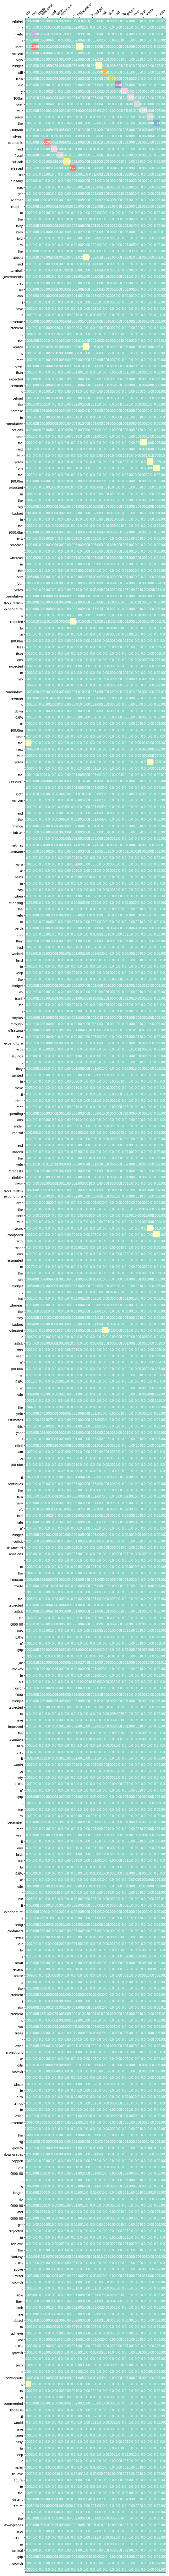

<Figure size 1440x864 with 0 Axes>

In [374]:
width = round(len(out_text))

fig, ax = plt.subplots(figsize=(160,width))

im = plt.imshow(x, interpolation='nearest')


ax.set_xticks(np.arange(len(trans_)))
ax.set_yticks(np.arange(len(example_)))

ax.set_xticklabels(trans_)
ax.set_yticklabels(example_)

ax.xaxis.tick_top()

plt.setp(ax.get_xticklabels(), rotation=45)

for i in range(len(example_)):
    for j in range(len(trans_)):
        text = ax.text(j, i, x[i, j],
                       ha="center", va="center", color="w")


fig.tight_layout()
plt.show()
plt.savefig('dissertation_cluster/figs/attention.pdf')

## Plotting encoder representations with UMAP

In [73]:
def get_encoder_outputs(src_sents, src_seqs, src_lens, encoder):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)

    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        
    encoder.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())
    
    return encoder_outputs, encoder_hidden

In [81]:
encoder_hidden[0].size()

torch.Size([2, 16, 512])

In [84]:
encoder_hidden[1].size()

torch.Size([2, 16, 512])

In [75]:
dataset = valid_iter

enc_outs = []
enc_hidden = []
enc_hidden_l1 = []
enc_hidden_l2 = []

for batch_id, batch_data in tqdm(enumerate(dataset)):
    src_sents, tgt_sents, src_seqs, tgt_seqs, src_lens, tgt_lens = batch_data
    
    encoder_outputs, encoder_hidden = get_encoder_outputs(src_sents, src_seqs, src_lens, encoder)
    
    encoder_outputs_cpu = encoder_outputs.cpu()
    encoder_hidden_l1_cpu = torch.cat((encoder_hidden[0][1],encoder_hidden[0][0]),1).cpu()
    encoder_hidden_l2_cpu = torch.cat((encoder_hidden[1][1],encoder_hidden[1][0]),1).cpu()
    
    encoder_outputs_np = encoder_outputs_cpu.data.numpy()
    encoder_hidden_l1_np = encoder_hidden_l1_cpu.data.numpy()
    encoder_hidden_l2_np = encoder_hidden_l2_cpu.data.numpy()
    
    enc_outs.append(encoder_outputs_np)
    enc_hidden_l1.append(encoder_hidden_l1_np)
    enc_hidden_l2.append(encoder_hidden_l2_np)


Process Process-22:
Process Process-21:
Process Process-23:
Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2e32be77f0>>
Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 340, in _shutdown_workers
    self.worker_result_queue.put(None)
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt: 


AttributeError: 'tuple' object has no attribute 'cpu'

Traceback (most recent call last):
Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/multiprocessing/process.py", line 93, in run
    sel

In [50]:
# not sure if this is really useful... what exactly are enc_states?

n_states = []
#can take state at different t during encoder
state = 400

for i in range(len(enc_outs)):
    n_state_batch = enc_outs[i][state]
    n_states.append(n_state_batch)

enc_state = np.vstack(n_states)

In [326]:
# opts {enc_state, enc_hidden_l1, enc_hidden_l2}
layer_ = enc_hidden_l1

layer = np.vstack(layer_)

In [327]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.2, metric='cosine')

In [328]:
embedding = reducer.fit_transform(layer)
embedding.shape

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 4 connected components using meta-embedding (experimental)
  n_components


(25507, 2)

In [329]:
import hdbscan

In [330]:
cd ~

/afs/inf.ed.ac.uk/user/s04/s0451365


In [331]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=200
).fit_predict(embedding)

In [332]:
dbmin = min(labels)
dbmax = max(labels)
print(dbmin, dbmax)

-1 2


In [333]:
num_clusters = len(set(labels))
num_clusters

4

In [334]:
clusters = list(set(labels))

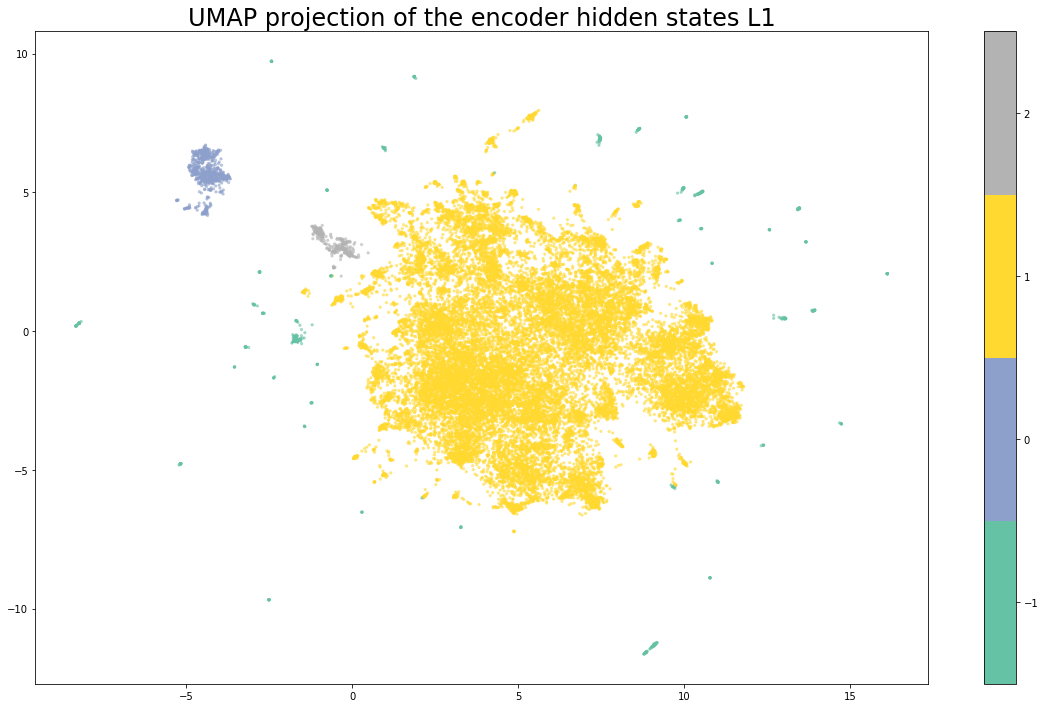

In [337]:
cmap = plt.get_cmap('Set2', num_clusters)

norm= matplotlib.colors.BoundaryNorm(np.arange(-1,num_clusters)-0.5, num_clusters)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#norm = matplotlib.colors.BoundaryNorm(np.arange(dbmin,dbmax,1), cmap.N)

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=5, alpha=0.5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the encoder hidden states L1', fontsize=24);

sm.set_array([])
plt.colorbar(sm, ticks=np.arange(-1,num_clusters))

savefig('dissertation_cluster/figs/umap_hidden_l1_clusters.pdf')

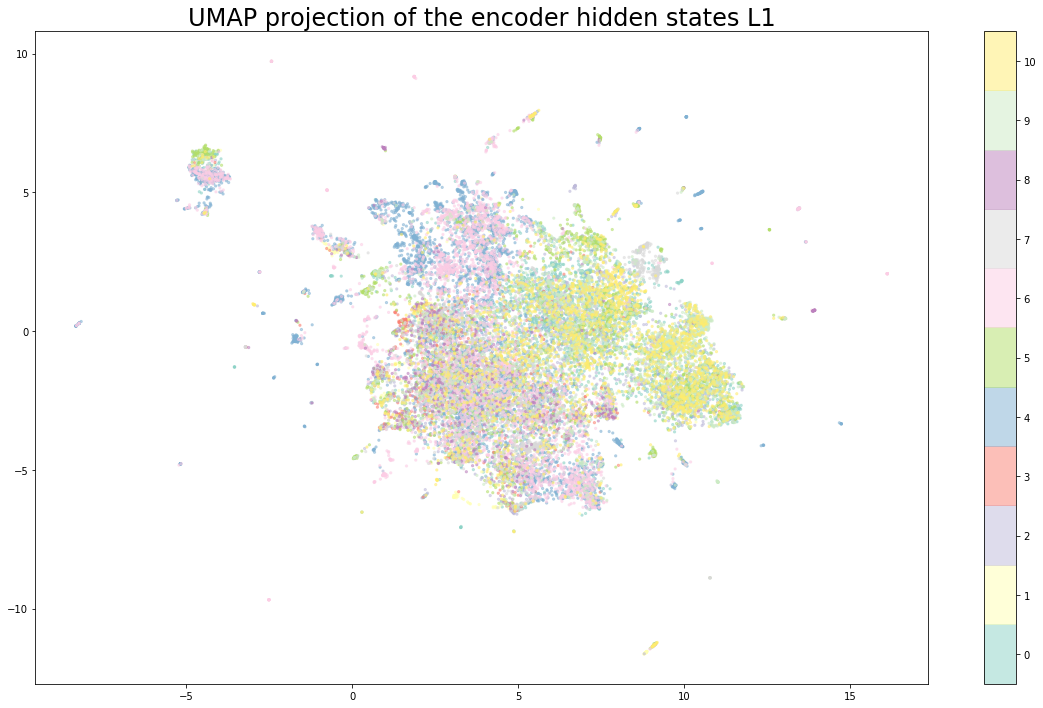

In [339]:
cmap = set_cmap('Set3')

#norm = matplotlib.colors.BoundaryNorm(np.arange(dbmin,dbmax,1), cmap.N)

plt.scatter(embedding[:, 0], embedding[:, 1], c=num_labs, cmap=cmap, s=5, alpha=0.5)
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))
plt.title('UMAP projection of the encoder hidden states L1', fontsize=24);
#colorbar_index(ncolors=11, cmap=cmap) 
savefig('dissertation_cluster/figs/umap_hidden_l1_sections.pdf')

In [340]:
import pandas as pd

In [341]:
str(round(embedding[1][0],1)) + " , " + str(round(embedding[1][1],1))

'3.1 , -1.9'

In [342]:
src_text = []
tgt_text = []
coods = []

dataset = valid_dataset

for i in range(len(dataset)):
    src_text_ = " ".join(dataset.__getitem__(i)[0])
    tgt_text_ = " ".join(dataset.__getitem__(i)[1])
    coods_ = str(round(embedding[i][0],1)) + " , " + str(round(embedding[i][1],1))
    src_text.append(src_text_)
    tgt_text.append(tgt_text_)
    coods.append(coods_)

testout_df = pd.DataFrame(np.column_stack([src_text, tgt_text, out_texts, num_labs, labels, coods]), columns=['src_text', 'tgt_text', 'translation', 'section', 'cluster_lab', 'coords'])


In [362]:
testout_df.loc[testout_df['cluster_lab'] == '1']['src_text'].iloc[4]

'theresa may is not back pedalling on her pledge to give workers a voice on company boards , the business secretary has said in response to criticism of the government s announcement that it will not force companies to give employees a governance position . related : theresa may to unveil boardroom crackdown on private big business the government unveiled proposals on tuesday to tackle corporate excess . may had raised the prospect of placing employee representatives on boards during her conservative leadership campaign over the summer , but has since told businesses she will not make them do so . greg clark said the prime minister wanted workers to be represented , but not necessarily by having an employee on the board . we are not going to make it happen , he told bbc radio 0 s today programme , adding that the government did not want to overturn what has been a successful system which has had the confidence of business around the world . what we are proposing today is a range of pro

In [344]:
testout_df.loc[testout_df['cluster_lab'] == '2']

,src_text,tgt_text,translation,section,cluster_lab,coords
104,high street retailers gained some relief from ...,<t> retail sales show january surge . sales we...,<t> high street retailers gained some relief f...,0,2,"-0.0 , 2.8"
709,"brakes , the london based food supplier that h...",<t> brakes sold to us company sysco in $0.0bn ...,<t> brakes in london to us company sysco in de...,0,2,"0.0 , 2.7"
980,investors protested against pay policies at tw...,<t> inmarsat shareholders vote against pay pol...,<t> investors protested against pay policies a...,0,2,"-0.4 , 2.7"
1124,"over the past 00 years , an astounding one bil...",<t> making international trade work for the wo...,<t> the poor and poor : the world trade group ...,0,2,"-0.3 , 2.0"
1900,the grattan institute this week published a re...,<t> work until 00 ? why old dogs must learn ne...,<t> the grattan : the grattan of the age of th...,0,2,"-0.1 , 2.8"
1929,has the behemoth had its day ? after years of ...,<t> tesco and rivals turn against hypermarkets...,<t> tesco : the latest news and best aside in ...,0,2,"-0.3 , 2.9"
3322,"alex poots , the founding director of manchest...",<t> manchester international festival founding...,<t> alex trustee : the director of manchester ...,1,2,"-0.7 , 3.1"
3343,"in the afternoon of 0 june , the queen will ma...",<t> david starkey : i can be a bit harsh . whe...,<t> the queen elizabeth : the queen is the flo...,1,2,"-0.9 , 3.2"
3348,dear doctor new doctor peter capaldis who cred...,<t> populist : items of interest this week . f...,<t> the new trailer : the new trailer video is...,1,2,"-0.5 , 2.9"
3415,"comic con international , san diego s annual c...",<t> conan obrien kicks off comic con 0000 in m...,<t> the convention : the convention of the con...,1,2,"-0.6 , 2.9"


## predicting sections using encoder layer

In [30]:
class DropNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 200)
        self.drop = nn.Dropout()
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 11)
        
    def forward(self, x):
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 11)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [32]:
net = Net().cuda()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=11, bias=True)
)


In [59]:
# optimizer
learning_rate=0.01

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# loss function
criterion = nn.NLLLoss()

NameError: name 'net' is not defined

In [45]:
def forward_encoder_mlp(src_seqs, src_lens, tgt, encoder, mode='train'):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)

    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)
        tgt = torch.LongTensor(tgt)
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt = tgt.cuda()
        
    encoder.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())
        
        encoder_hidden_l1 = torch.cat((encoder_hidden[0][1],encoder_hidden[0][0]),1)
        encoder_hidden_l2 = torch.cat((encoder_hidden[1][1],encoder_hidden[1][0]),1)
    
    if mode == 'test':
        with torch.no_grad():
            net_out = net(encoder_hidden_l2)
    else:
        net_out = net(encoder_hidden_l2)
    
    loss = criterion(net_out, torch.max(tgt, 1)[1])
    
    return net_out, loss, tgt

In [46]:
# run the main training loop
epochs = 1
dataset = train_mlp_iter
log_interval = 1000
iterations=0
correct=0

for epoch in range(epochs):
    for batch_id, batch_data in tqdm(enumerate(dataset)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

        batch_size = len(src_sents)
        
        optimizer.zero_grad()
        
        net_out, loss, tgt = forward_encoder_mlp(src_seqs, src_lens, tgts, encoder, 'train')
        
        loss.backward()
        optimizer.step()
    
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    
        iterations += batch_size
        correct += pred.eq(torch.max(tgt, 1)[1]).sum()
        
        if batch_id % log_interval == 0:
            print('Training Accuracy: {}/{} ({:.0f}%)\n'.format(
                   correct, iterations,
                100. * correct / iterations))

        # Free memory
        del src_sents, src_seqs, tgts, src_lens, net_out, loss, tgt

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Accuracy: 3/16 (18%)

Training Accuracy: 3611/16016 (22%)

Training Accuracy: 7997/32016 (24%)

Training Accuracy: 12599/48016 (26%)

Training Accuracy: 17404/64016 (27%)

Training Accuracy: 22359/80016 (27%)

Training Accuracy: 27537/96016 (28%)

Training Accuracy: 32805/112016 (29%)

Training Accuracy: 38161/128016 (29%)

Training Accuracy: 43742/144016 (30%)

Training Accuracy: 49373/160016 (30%)

Training Accuracy: 55076/176016 (31%)

Training Accuracy: 60885/192016 (31%)




In [48]:
test_loss = 0
correct = 0

for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
    
    src_sents, src_seqs, tgts, src_lens, scts = batch_data
    
    net_out, loss, tgt = forward_encoder_mlp(src_seqs, src_lens, tgts, encoder, 'test')
    # sum up batch loss
    
    test_loss += loss
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    
    correct += pred.eq(torch.max(tgt, 1)[1]).sum()

test_loss /= valid_mlp_dataset.__len__()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, valid_mlp_dataset.__len__(),
        100. * correct / valid_mlp_dataset.__len__()))

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




Test set: Average loss: 0.1349, Accuracy: 5659/25507 (22%)



In [49]:
from random import shuffle

In [62]:
val_section_labels_rnd = val_section_labels.copy()

shuffle(val_section_labels_rnd)

In [73]:
accs = []
for t in range(5):
    match = 0
    shuffle(val_section_labels_rnd)
    for i,j in zip(val_section_labels, val_section_labels_rnd):
        if i == j:
            match += 1
        
    acc = match/len(val_section_labels)
    accs.append(acc)
print(accs)
print('Chance level accuracy: ', round(100*np.mean(accs),2), '%')

[0.12192731407064727, 0.12392676520170934, 0.12475006860861725, 0.12463245383620182, 0.12498529815344807]
Chance level accuracy:  12.4 %


## Train RNN classifier

In [29]:
class RNN_classifier(nn.Module):
    def __init__(self, embedding=None, rnn_type='LSTM', hidden_size=256, num_layers=2, dropout=0, bidirectional=True):
        super(RNN_classifier, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        #self.drop = nn.Dropout()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size // self.num_directions
        
        self.embedding = embedding
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                           input_size=self.word_vec_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.dropout, 
                           bidirectional=self.bidirectional)
        
        self.fc1 = nn.Linear(256, 11)
        
    def forward(self, src_seqs, src_lens, hidden=None):
        """
        Args:
            - src_seqs: (max_src_len, batch_size)
            - src_lens: (batch_size)
        Returns:
            - outputs: (max_src_len, batch_size, hidden_size * num_directions)
            - hidden : (num_layers, batch_size, hidden_size * num_directions)
        """
        
        # (max_src_len, batch_size) => (max_src_len, batch_size, word_vec_size)
        emb = self.embedding(src_seqs)

        # packed_emb:
        # - data: (sum(batch_sizes), word_vec_size)
        # - batch_sizes: list of batch sizes
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb, src_lens)
        

        # rnn(gru) returns:
        # - packed_outputs: shape same as packed_emb
        # - hidden: (num_layers * num_directions, batch_size, hidden_size) 
        packed_outputs, hidden = self.rnn(packed_emb, hidden)

        # outputs: (max_src_len, batch_size, hidden_size * num_directions)
        # output_lens == src_lensˇ
        outputs, output_lens =  nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        #hidden_ = torch.cat((hidden[0][1],hidden[0][0]),1)
        #context = torch.cat((hidden[1][1],hidden[1][0]),1)
        
        if self.bidirectional:
            # (num_layers * num_directions, batch_size, hidden_size) 
            # => (num_layers, batch_size, hidden_size * num_directions)
            hidden = self._cat_directions(hidden)
        
        #drop = self.drop(hidden_l1)
            
        # MLP takes one hidden layer. ix here is the encoder layer
        x = F.relu(self.fc1(outputs[-1]))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        #x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden

In [30]:
# Initialize models.
RNNclassifier = RNN_classifier(embedding=src_embedding,
                     rnn_type='GRU',
                     hidden_size=256,
                     num_layers=1,
                     dropout=0,
                     bidirectional=True)

if USE_CUDA:
    RNNclassifier.cuda()

In [31]:
print(RNNclassifier)

RNN_classifier(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): GRU(300, 128, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=11, bias=True)
)


In [35]:
tgt

NameError: name 'tgt' is not defined

In [32]:
# Initialize optimizers (we can experiment different learning rates)
RNNclassifier_optim = optim.Adam([p for p in RNNclassifier.parameters() if p.requires_grad], lr = 1e-3)
#RNNclassifier_optim = optim.RMSprop([p for p in RNNclassifier.parameters() if p.requires_grad])
#RNNclassifier_optim = optim.SGD(RNNclassifier.parameters(), lr = 1e-2)

# loss function
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

In [54]:
def RNN_classifier(src_seqs, src_lens, tgt, mode='train'):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    src_seqs = src_seqs
    src_lens = torch.LongTensor(src_lens)
    tgt = torch.LongTensor(tgt)
    
    assert(batch_size == tgt.size(0))
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt = tgt.cuda()
    
    if mode == 'train':
        
        RNNclassifier.train()
        
    # -------------------------------------
    # Zero gradients, since optimizers will accumulate gradients for every backward.
    # -------------------------------------
        RNNclassifier_optim.zero_grad()
        
        RNNclass_out = RNNclassifier(src_seqs, src_lens.data.tolist())
        
        loss = criterion(RNNclass_out, torch.max(tgt, 1)[1])
        
        loss.backward()
        
            # Clip gradients
        RNNclassifier_grad_norm = nn.utils.clip_grad_norm_(RNNclassifier.parameters(), opts.max_grad_norm)
        clipped_RNNclassifier_grad_norm = compute_grad_norm(RNNclassifier.parameters())

    
        RNNclassifier_optim.step()
        
        
    
    elif mode == 'test':
        
        RNNclassifier.eval()
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
        with torch.no_grad():
            RNNclass_out = RNNclassifier(src_seqs, src_lens.data.tolist())
    
            loss = criterion(RNNclass_out, torch.max(tgt, 1)[1])
        
    
    return RNNclass_out, loss, tgt

In [39]:
for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

In [53]:
torch.LongTensor(tgts).size(0)

128

In [55]:
# train LSTM encoder + MLP for max accuracy
experiment_name = 'RNN_classifier_dropout_seqs400'

total_loss = 0
total_corrects = 0
total_words = 0
global_step = 0
iterations = 0

epochs = 1
dataset = train_mlp_iter
log_interval = 200

for epoch in range(epochs):
    for batch_id, batch_data in tqdm(enumerate(dataset)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

        batch_size = len(src_sents)
    
        
        RNNclass_out, loss, tgt = RNN_classifier(src_seqs, src_lens, tgts, 'train')
    
        pred = RNNclass_out.data.max(1)[1]  # get the index of the max log-probability
    
        iterations += batch_size
        num_corrects = pred.eq(torch.max(tgt, 1)[1]).sum()
        
        batch_accuracy = round(100 * (float(num_corrects) / batch_size))
        global_step += 1
        total_loss += loss
        total_corrects += num_corrects
        total_accuracy = round(100 * (total_corrects.item() / iterations),2)
        avg_loss = round(100 * (total_loss.item() / iterations),2)
        
        if batch_id % log_interval == 0:
            print('Training: Overall Accuracy: {}/{} ({:.0f}%), batch accuracy: {}, loss: {}\n'.format(
                   total_corrects, iterations,
                total_accuracy,batch_accuracy, avg_loss))

        # Free memory
        del src_sents, src_seqs, tgts, src_lens, RNNclass_out, loss, tgt

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training: Overall Accuracy: 31/128 (24%), batch accuracy: 24, loss: 1.86

Training: Overall Accuracy: 5029/25728 (20%), batch accuracy: 23, loss: 1.77

Training: Overall Accuracy: 11157/51328 (22%), batch accuracy: 28, loss: 1.71

Training: Overall Accuracy: 19011/76928 (25%), batch accuracy: 35, loss: 1.65

Training: Overall Accuracy: 27631/102528 (27%), batch accuracy: 40, loss: 1.6

Training: Overall Accuracy: 37042/128128 (29%), batch accuracy: 45, loss: 1.56

Training: Overall Accuracy: 47661/153728 (31%), batch accuracy: 41, loss: 1.53

Training: Overall Accuracy: 59000/179328 (33%), batch accuracy: 40, loss: 1.5




In [ ]:
#experiment_name = 'RNN_classifier_dropout_seqs1000'

In [39]:
def save_class_checkpoint(opts, experiment_name, encoder, encoder_optim,
                    total_accuracy, total_loss, global_step):
    checkpoint = {
        'opts': opts,
        'global_step': global_step,
        'encoder_state_dict': RNNclassifier.state_dict(),
        'encoder_optim_state_dict': RNNclassifier_optim.state_dict()
    }
    
    checkpoint_path = 'checkpoints/%s_acc_%.2f_loss_%.2f_step_%d.pt' % (experiment_name, total_accuracy, total_loss, global_step)
    
    directory, filename = os.path.split(os.path.abspath(checkpoint_path))

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(checkpoint, checkpoint_path)
    
    return checkpoint_path

In [ ]:
checkpoint_path = save_class_checkpoint(opts, experiment_name, encoder, encoder_optim, 
                                              total_accuracy, total_loss, global_step)

In [35]:
LOAD_CHECKPOINT = True

if LOAD_CHECKPOINT:
    # Modify this path.
    checkpoint_path = 'checkpoints/RNN_classifier_dropout_base_acc_53.14_loss_17432.52_step_12754.pt'
    checkpoint = load_checkpoint(checkpoint_path)
    opts = checkpoint['opts']    
    
if LOAD_CHECKPOINT:
    RNNclassifier.load_state_dict(checkpoint['encoder_state_dict'])

RuntimeError: Error(s) in loading state_dict for RNN_classifier:
	Unexpected key(s) in state_dict: "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 
	While copying the parameter named "rnn.bias_ih_l0_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_ih_l1", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l1", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_ih_l1_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l0", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.weight_ih_l0", whose dimensions in the model are torch.Size([512, 300]) and whose dimensions in the checkpoint are torch.Size([1024, 300]).
	While copying the parameter named "rnn.weight_hh_l1_reverse", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.bias_ih_l0", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l0_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l1_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.weight_ih_l0_reverse", whose dimensions in the model are torch.Size([512, 300]) and whose dimensions in the checkpoint are torch.Size([1024, 300]).
	While copying the parameter named "rnn.weight_ih_l1_reverse", whose dimensions in the model are torch.Size([512, 256]) and whose dimensions in the checkpoint are torch.Size([1024, 512]).
	While copying the parameter named "rnn.weight_hh_l1", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.weight_hh_l0", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.weight_ih_l1", whose dimensions in the model are torch.Size([512, 256]) and whose dimensions in the checkpoint are torch.Size([1024, 512]).
	While copying the parameter named "rnn.weight_hh_l0_reverse", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "fc1.weight", whose dimensions in the model are torch.Size([11, 256]) and whose dimensions in the checkpoint are torch.Size([200, 1024]).
	While copying the parameter named "fc1.bias", whose dimensions in the model are torch.Size([11]) and whose dimensions in the checkpoint are torch.Size([200]).

In [56]:
test_loss = 0
correct = 0
preds = []
tgts_ = []

for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
    
    src_sents, src_seqs, tgts, src_lens, scts = batch_data
    
    RNNclass_out, loss, tgt = RNN_classifier(src_seqs, src_lens, tgts, 'test')
    # sum up batch loss
   
    test_loss += loss
    pred = RNNclass_out.data.max(1)[1]  # get the index of the max log-probability
    
    tgt_ = torch.max(tgt, 1)[1]
    correct += pred.eq(tgt_).sum()
    
    preds.append(pred)
    tgts_.append(tgt_)
    
    # Free memory
    del src_sents, src_seqs, src_lens

test_loss /= valid_mlp_dataset.__len__()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, valid_mlp_dataset.__len__(),
        100 * correct / valid_mlp_dataset.__len__()))



Test set: Average loss: 0.2872, Accuracy: 6413/25507 (25%)

